# Recomendação de Conteúdo - Filtragem Colaborativa

Este notebook mostra os detalhes da construção e a avaliação de um recomendador de conteúdos, baseado em Filtragem Colaborativa. Em nosso experimento utilizaremos os dados fornecidos pela MovieLens, um dataset gratuito criado e mantido pelo grupo de pesquisas da Universidade de Minnesota (GroupLens).

Dataset disponível em: https://grouplens.org/datasets/movielens

Para executar este experimento, é necessário instalar os seguintes pacotes via <b>pip</b>:
* pyspark
* matplotlib
* pandas

In [1]:
from pyspark.sql import SparkSession

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

import matplotlib.pyplot as plt
import pandas as pd

O dataset disponibilizado pela GroupLens é constituído por quatro dimensões, são elas: user_id, movie_id, rating e timestamp. Estes dados representam o consumo e a avaliação de um filme por um usuário.

Os dados são lidos através de um RDD para que possam ser disponibilizados na estrutura de um Dataframe. Uma vez nessa estrutura os dados pode ser facilmente consultados e manipulados.

In [2]:
spark = SparkSession.builder.appName("collaborative_filtering").getOrCreate()
lines = spark.read.text("ratings.csv").rdd
parts = lines.map(lambda row: row.value.split(","))

ratingsRDD = parts.map(lambda p: Row(user=int(p[0]), movie=int(p[1]), rating=float(p[2]), timestamp=long(p[3])))

A seguir, apresentamos a disponibilização dos dados em um Dataframe:

In [3]:
ratings = spark.createDataFrame(ratingsRDD)
ratings.show(5)

+-----+------+----------+----+
|movie|rating| timestamp|user|
+-----+------+----------+----+
|   31|   2.5|1260759144|   1|
| 1029|   3.0|1260759179|   1|
| 1061|   3.0|1260759182|   1|
| 1129|   2.0|1260759185|   1|
| 1172|   4.0|1260759205|   1|
+-----+------+----------+----+
only showing top 5 rows



Com o objetivo de medir a acurácia e capacidade de generalização do recomendador de conteúdos, vamos separar o dataset em duas partes: Treino e teste. O dataset de treino é composto por 80% dos dados e será utilizado para treinar o recomendador. Os 20% dos dados que são desconhecidos pelo recomendador (conjunto de teste) será utilizado para medir a capacidade do modelo em predizer a avaliação que um usuário daria para um filme, em outras palavras, o quanto um usuário vai gostar de um filme.

In [4]:
(training, test) = ratings.randomSplit([0.8, 0.2])

A seguir, criamos e treinamos um modelo utilizando o dataset de treino. Para evitar exceções geradas pelo cold start, atribuímos o valor "drop" ao parâmetro "coldStartStrategy"; isso faz com que um dado que esteja no conjunto de teste e não esteja no conjunto de treino seja ignorado durante a validação.

In [5]:
als = ALS(maxIter=5, regParam=0.1, userCol="user", itemCol="movie", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

Depois de treinado, utilizaremos o modelo para predizer as notas que cada usuário daria para cada filme. Estas predições são representadas em uma estrutura de Dataframe. Para avaliar a capacidade de predição do modelo, utilizaremos uma regressão para analisar o quanto os valores preditos se desviam em relação aos valores reais.

In [6]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.916498741802


A meneira mais comum de avaliar os resultados de uma regressão é olhando a raiz do erro quadrático médio, no entanto essa medida por si só não mostra as situações onde o modelo tem melhor ou pior comportamento.

A seguir apresentamos a matriz de resultados preditos:

In [7]:
predictions.show(5, truncate = False)

+-----+------+----------+----+----------+
|movie|rating|timestamp |user|prediction|
+-----+------+----------+----+----------+
|471  |5.0   |833287141 |126 |3.788468  |
|471  |5.0   |1074104142|274 |3.5690942 |
|471  |3.0   |835337519 |440 |3.2024858 |
|471  |4.0   |1114565458|309 |4.01558   |
|471  |4.0   |1118247731|607 |3.4661555 |
+-----+------+----------+----+----------+
only showing top 5 rows



Para avaliar as situações em que o modelo se comporta bem, vamos utilizar histogramas que medem o desempenho do recomendados para cada classe de nota (1 a 5).

A seguir, definimos uma função para plotar os histogramas:

In [8]:
def plot_hist(data, h=0.4):
    %matplotlib inline
    
    n, bins, patches = plt.hist(data, 20, normed=5, facecolor='g', alpha=0.9)
    plt.xlabel('Value')
    plt.ylabel('Quantity')
    plt.title('Histogram')
    plt.axis([0, 7, 0, h])
    plt.grid(True)

    plt.show()

Comportamento de predições da Nota 1:

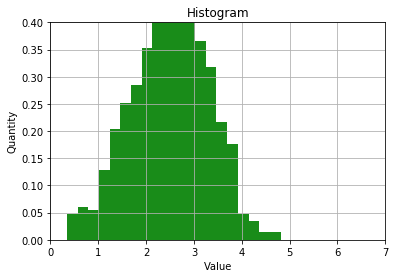

In [9]:
_1 = predictions.filter(predictions.rating == 1).cache()
data = [i.prediction for i in _1.select("prediction").collect()]

plot_hist(data)

Comportamento de predições da Nota 2:

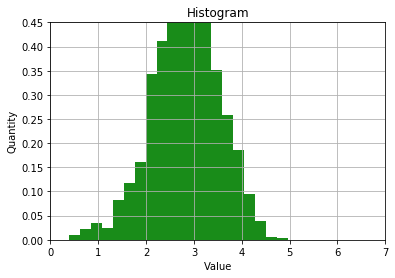

In [10]:
_2 = predictions.filter(predictions.rating == 2).cache()
data = [i.prediction for i in _2.select("prediction").collect()]

plot_hist(data, h=0.45)

Comportamento de predições da Nota 3:

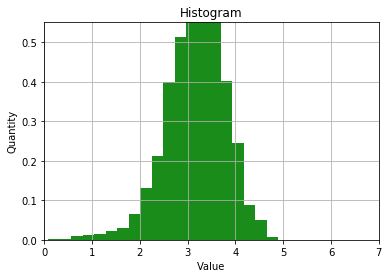

In [11]:
_3 = predictions.filter(predictions.rating == 3).cache()
data = [i.prediction for i in _3.select("prediction").collect()]

plot_hist(data, h=0.55)

Comportamento de predições da Nota 4:

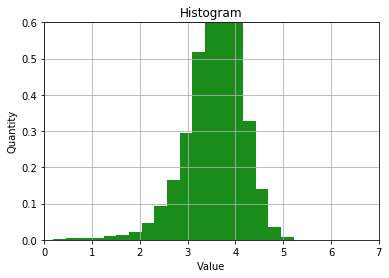

In [12]:
_4 = predictions.filter(predictions.rating == 4).cache()
data = [i.prediction for i in _4.select("prediction").collect()]

plot_hist(data, h=0.6)

Comportamento de predições da Nota 5:

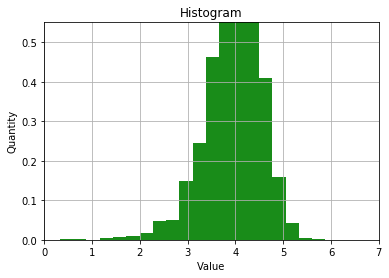

In [13]:
_5 = predictions.filter(predictions.rating == 5).cache()
data = [i.prediction for i in _5.select("prediction").collect()]

plot_hist(data, h=0.55)

A seguir, vamos calcular a matriz de recomendações para os usuários. Neste experimento vamos calcular cinco recomendações para cada usuário.

In [14]:
recommendations = model.recommendForAllUsers(5).orderBy("user")
recommendations.show(5, truncate = False)

+----+---------------------------------------------------------------------------------------------+
|user|recommendations                                                                              |
+----+---------------------------------------------------------------------------------------------+
|1   |[[3414,4.0289984], [5269,3.9783134], [149,3.9417744], [2907,3.8959832], [4518,3.883263]]     |
|2   |[[83318,5.029491], [67504,5.029491], [83359,5.029491], [65037,4.7004642], [59684,4.7004642]] |
|3   |[[67504,4.96786], [83318,4.96786], [83359,4.96786], [3414,4.598306], [6375,4.5866923]]       |
|4   |[[83318,6.6599126], [67504,6.6599126], [83359,6.6599126], [6918,6.0000196], [7074,5.9939218]]|
|5   |[[59684,4.9989014], [65037,4.9989014], [3414,4.9458013], [106471,4.916339], [4086,4.9105406]]|
+----+---------------------------------------------------------------------------------------------+
only showing top 5 rows



Depois de calculadas, vamos exibir as recomendações e suas respectivas notas para o usuário de identificador 1:

In [15]:
df = recommendations.filter(recommendations.user == 1).select("recommendations")
df.show(truncate = False)

+----------------------------------------------------------------------------------------+
|recommendations                                                                         |
+----------------------------------------------------------------------------------------+
|[[3414,4.0289984], [5269,3.9783134], [149,3.9417744], [2907,3.8959832], [4518,3.883263]]|
+----------------------------------------------------------------------------------------+



Vamos isolar os identificadores dos filmes na ordem de recomendação, isso facilitará a manipulação.

In [16]:
movie_ids = [x.movie for x in df.collect()[0][0]]
print movie_ids

[3414, 5269, 149, 2907, 4518]


A seguir, carregamos o arquivo "movie.csv". Esse arquivo contém o identificador, título e gênero de cada filme.

In [17]:
movies = pd.read_csv("movies.csv", names=["id", "title", "genres"])
movies.head(5)

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


A seguir, buscamos os filmes recomendados para o usuário de identificador 1, exibindo id, titulo e gênero dos filmes:

In [18]:
movies.query("id in (%s)" % (reduce(lambda x, y: str(x) + "," + str(y), movie_ids)))

,id,title,genres
128,149,Amateur (1994),Crime|Drama|Thriller
2333,2907,Superstar (1999),Comedy
2722,3414,Love Is a Many-Splendored Thing (1955),Drama|Romance|War
3559,4518,The Lair of the White Worm (1988),Comedy|Horror
4036,5269,"Piano Teacher, The (La pianiste) (2001)",Drama


A seguir, exibimos a lista de filmes assistidos pelo usuário de identificador 1:

In [19]:
view = ratings.filter(ratings.user == 1).select("movie").collect()
movies.query("id in (%s)" % (",".join("{0}".format(x.movie) for x in view)))

,id,title,genres
30,31,Dangerous Minds (1995),Drama
833,1029,Dumbo (1941),Animation|Children|Drama|Musical
859,1061,Sleepers (1996),Thriller
906,1129,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
931,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
1017,1263,"Deer Hunter, The (1978)",Drama|War
1041,1287,Ben-Hur (1959),Action|Adventure|Drama
1047,1293,Gandhi (1982),Drama
1083,1339,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
1087,1343,Cape Fear (1991),Thriller
